In [2]:
import pandas as pd
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import re
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
import dill
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from functools import reduce
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import TimeSeriesSplit


First we will get the weather data

In [ ]:
date_cols = ['valid']
weather_df = pd.read_csv('NYC_May_25_2023_weather_data.csv', parse_dates=date_cols)

In [ ]:
class WeatherExpander(BaseEstimator, RegressorMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Return a pandas data frame from X
        X = X[['valid', 'tmpf', 'sknt', 'wxcodes']]
        X = X.replace({np.nan: 'no_weather'})
        X['rain'] = np.where(X['wxcodes'].str.contains('RA'), 1, 0)
        X['snow'] = np.where(X['wxcodes'].str.contains('SN'), 1, 0)
        return X[['valid',  'tmpf', 'sknt', 'rain', 'snow']]#pd.DataFrame.from_dict(X, orient='columns')

class NoNoneWeather(BaseEstimator, RegressorMixin):
     def fit(self, X, y=None):
        return self
    
     def transform(self, X):
        X['tmpf'].interpolate(method='linear')  
#         X['sknt'].interpolate(method='linear', limit=None) 
        X['sknt'] = X['sknt'].fillna('0.00')
        return X


In [ ]:
weather_transform = WeatherExpander()
no_none_temp = NoNoneWeather()
weather = Pipeline([
    ('add snow and rain columns', weather_transform),
    ('no nan in tmpf', no_none_temp)
])

transformed_weather_df = weather.transform(weather_df)

In [ ]:
transformed_weather_df.head()

Now we will get the citibike data

In [ ]:
file_list = ['citibike_tracker_helen_export_through_May_4 at_1530.json', 
            'citibike_tracker_helen_export_through_May_13_at_1030.json', 
            'citibike_tracker_helen_export_through_May_24_at_1450.json'] 
data_list = []
for file in file_list:
    with open(file) as json_file:
        data_list.append(json.load(json_file))

In [ ]:
dat = {}
for file in data_list:
    for k,v in file.items():
        dat[k] = v

In [ ]:
def get_free_bikes(data):
    just_free_bikes = []
    station_ids = data['1680321605542'].keys()
    times = data.keys()
    stn1 = ['5006','5006']
    all_station_list_of_df = []
    for station in station_ids:
        station_data = ['bike_angels_action', 'bike_angels_points', 'bikes_available', 
                        'docks_available', 'ebikes_available', 'terminal']
        all_data_for_one_station = {}
        for dat in station_data:
            hold = []
            time_act = []
            for time in times:
                if station in data[time].keys():
                    time_act.append(time)
                    hold.append(data[time][station][dat])
            all_data_for_one_station[dat] = hold
        
        df_one_station = pd.DataFrame(all_data_for_one_station, index = time_act)

        df_one_station['free_ebikes'] = np.where((df_one_station['ebikes_available']>0) & (df_one_station['bikes_available']==df_one_station['ebikes_available'] ), 1, 0)     
        df_one_station['date'] = df_one_station.index.astype('int')//1000
        df_one_station['date'] = pd.to_datetime(df_one_station['date'], unit='s')
        df_one_station['year'] = df_one_station['date'].dt.strftime('%Y')
        df_one_station['month'] = df_one_station['date'].dt.strftime('%m')
        df_one_station['hour'] = pd.to_datetime(df_one_station['date'], format='%H:%M:%S').dt.hour
        df_one_station['day_of_week'] = df_one_station['date'].dt.weekday
        for i in range(1,7):
            df_one_station[i*10] = df_one_station['free_ebikes'].shift(-i) 
        df_one_station = df_one_station[df_one_station['free_ebikes'] == 1] 
        all_station_list_of_df.append(df_one_station)
    return all_station_list_of_df
            
all_station_list_of_df = get_free_bikes(dat)  
# all_station_list_of_df[0]
bike_df = pd.concat(all_station_list_of_df).reset_index()

In [ ]:
bike_df.shape

Let's put the two frames together by finding the weather that fits with that station at each time

In [ ]:
def find_weather_row(row):
#     print(row.date)
    find_close = transformed_weather_df[abs(row.date - transformed_weather_df['valid']) < timedelta(minutes=30)]['valid']
#     time_to_add = transformed_weather_df[abs(bike_df['date'][row]- transformed_weather_df['valid']) < timedelta(minutes=30)]['valid'].iloc[0]
#     print('the closest time is :' , find_close.iloc[0])
    if find_close.shape[0] > 0:
        return find_close.iloc[0]
#         print(find_close.iloc[0])
    else:
        return None

def add_two(row):
    return row.bike_angels_points + 2

# find_weather_row(1316142)
some_bike_df = bike_df[:100:20].copy()
# some_bike_df['weather_date'] = some_bike_df.bikes_available.apply(add_two)
# # # df = pd.concat([df, applied_df], axis='columns')
# some_bike_df.tail()

# some_bike_df.head()
bike_df['a'] = bike_df.apply(find_weather_row, axis = 1)
# some_bike_df['a'] = some_bike_df.apply(add_two, axis = 1)
bike_df.head()

# transformed_weather_df[abs(some_bike_df['date']- transformed_weather_df['valid']) < timedelta(minutes=30)]['valid']

In [ ]:
with open('currnet_freebikes_with_weather_times.pkd', 'wb') as f:
    dill.dump(bike_df, f)

In [ ]:
with open('currnet_freebikes_with_weather_times.pkd', 'rb') as f:
    bike_df_test = dill.load(f)
bike_df_test.shape

In [ ]:
bike_weather_df = bike_df_test.merge(transformed_weather_df, how='left', left_on='a', right_on='valid')
bike_weather_df = bike_weather_df.rename(columns={'tmpf': 'temp', 'sknt': 'wind'})
bike_weather_df.wind = bike_weather_df.wind.replace('M', np.NaN)
bike_weather_df = bike_weather_df.dropna(axis=0)
bike_weather_df['hold'] = bike_weather_df['bike_angels_action'].apply(lambda x: -1 if x == 'take' else 1)
bike_weather_df['bike_angels_points'] = bike_weather_df['bike_angels_points'] * bike_weather_df['hold']

bike_weather_df.head()

In [ ]:
# bike_weather_df.columns

In [ ]:
y_options = bike_weather_df[[10, 20, 30, 40, 50, 60]]
X = bike_weather_df[['date', 'bike_angels_points', 'bikes_available', 'docks_available', 'ebikes_available',
                 'terminal', 'hour', 'day_of_week', 'temp', 'wind', 'rain', 'snow']]

In [ ]:
with open('current_free_bikes_historical_live_bikes_X.pkd', 'wb') as f:
    dill.dump(X, f)

In [ ]:
with open('current_free_bikes_historical_live_bikes_y_options.pkd', 'wb') as f:
    dill.dump(y_options, f)

_______________________________________________________________
Let's build a logistic regression model
___________

In [ ]:
with open('current_free_bikes_historical_live_bikes_X.pkd', 'rb') as f:
    X = dill.load(f)
# len(X)

In [ ]:
with open('current_free_bikes_historical_live_bikes_y_options.pkd', 'rb') as f:
    y_options = dill.load(f)
# X.head(5)
# len(y_options)

In [ ]:
time = [10, 20, 30, 40, 50, 60]
scores_dict = {}
for min_late in time:
# X_train, X_test, y_train, y_test = train_test_split(X, y_options[min_late], test_size=0.25)
    X_train = X[:int(len(X)*0.8)]
    X_test = X[int(len(X)*0.8):]
    y_train = y_options[:int(len(y_options)*0.8)][min_late]
    y_test = y_options[int(len(y_options)*0.8):][min_late]

    numeric = ['bike_angels_points',  'docks_available', 'ebikes_available','temp', 'wind', 'rain', 'snow'] #'bikes_available',
    categorical = [  'day_of_week', 'hour']#, 'terminal']#,

    lr = LogisticRegression(n_jobs=-1)
    param_grid = {'C': np.logspace(-1, 0, 20), 'max_iter':[500]}
    tscv = TimeSeriesSplit(n_splits=5)
    gs = GridSearchCV(lr, param_grid, cv = tscv)# index_output)
    ohe = OneHotEncoder()
    ohe_final = ColumnTransformer([
          ('scale_numeric', StandardScaler(), numeric),
          ('ohe_categorical_features', ohe, categorical)
        ], remainder='drop')

    lr_pipe = Pipeline([('ohe', ohe_final),
                        ('grid search regressor', gs)])
    #                     ('regressor', lr)])

    lr_pipe.fit(X_train, y_train);
    y_pred = lr_pipe.predict(X_train)

    acc = metrics.accuracy_score(y_train, y_pred)
    prece = metrics.precision_score(y_train, y_pred)
    rec = metrics.recall_score(y_train, y_pred)

    probs = lr_pipe.predict_proba(X_train).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, probs)
    AUC = round(metrics.auc(recalls, precisions), 4)
    
    y_pred = lr_pipe.predict(X_train)
    print("Training accuracy:", acc)
    print('Precision: %.3f' % prece)
    print('Recall: %.3f' % rec)

#     probs = lr_pipe.predict_proba(X_train).T[1]
#     precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, probs)
#     AUC = round(metrics.auc(recalls, precisions), 4)
    print('AUC: %.3f' %AUC)
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.plot(recalls, precisions)
    plt.axis([0, 1, 0, 1])
    ax.set_aspect('equal', adjustable='box');
    
    scores_dict[min_late] = [acc, prece, rec, AUC]
    name_use = 'model_'+str(min_late)+'.pkd'
    with open(name_use, 'wb') as f:       
        dill.dump(lr_pipe, f)
        



_______________________________________
And now we can make a random forest model
____________________________

In [ ]:
with open('current_free_bikes_historical_live_bikes_X.pkd', 'rb') as f:
    X = dill.load(f)
with open('current_free_bikes_historical_live_bikes_y_options.pkd', 'rb') as f:
    y_options = dill.load(f)

In [ ]:
time = [10, 20, 30, 40, 50, 60]
scores_dict = {}
for min_late in time:
# X_train, X_test, y_train, y_test = train_test_split(X, y_options[min_late], test_size=0.25)
    X_train = X[:int(len(X)*0.8)]
    X_test = X[int(len(X)*0.8):]
    y_train = y_options[:int(len(y_options)*0.8)][min_late]
    y_test = y_options[int(len(y_options)*0.8):][min_late]

    numeric = ['bike_angels_points',  'docks_available', 'ebikes_available','temp', 'wind', 'rain', 'snow'] #'bikes_available',
    categorical = [  'day_of_week', 'hour']#, 'terminal']#,

    
    rf = RandomForestClassifier()
    param_grid = {'n_estimators': [200, 500, 1000],
                     'max_depth' : [4, 7, 10]}
#     lr = LogisticRegression(n_jobs=-1)
#     param_grid = {'C': np.logspace(-1, 0, 20), 'max_iter':[500]}
    tscv = TimeSeriesSplit(n_splits=5)
    gs = GridSearchCV(rf, param_grid, cv = tscv)# index_output)
    ohe = OneHotEncoder()
    ohe_final = ColumnTransformer([
          ('scale_numeric', StandardScaler(), numeric),
          ('ohe_categorical_features', ohe, categorical)
        ], remainder='drop')

    lr_pipe = Pipeline([('ohe', ohe_final),
                        ('grid search regressor', gs)])

    lr_pipe.fit(X_train, y_train);
    y_pred = lr_pipe.predict(X_train)

    acc = metrics.accuracy_score(y_train, y_pred)
    prece = metrics.precision_score(y_train, y_pred)
    rec = metrics.recall_score(y_train, y_pred)

    probs = lr_pipe.predict_proba(X_train).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, probs)
    AUC = round(metrics.auc(recalls, precisions), 4)
    
    y_pred = lr_pipe.predict(X_train)
    print("Training accuracy:", acc)
    print('Precision: %.3f' % prece)
    print('Recall: %.3f' % rec)

#     probs = lr_pipe.predict_proba(X_train).T[1]
#     precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, probs)
#     AUC = round(metrics.auc(recalls, precisions), 4)
    print('AUC: %.3f' %AUC)
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.plot(recalls, precisions)
    plt.axis([0, 1, 0, 1])
    ax.set_aspect('equal', adjustable='box');
    
    scores_dict[min_late] = [acc, prece, rec, AUC]
    name_use = 'rf_model_'+str(min_late)+'.pkd'
    with open(name_use, 'wb') as f:       
        dill.dump(lr_pipe, f)
        



_________
Let's evaluate how well each of the two models perform
________

First find the accuracy, precision, recall, and AUC for the logistic regression model

In [3]:
with open('current_free_bikes_historical_live_bikes_X.pkd', 'rb') as f:
    X = dill.load(f)
with open('current_free_bikes_historical_live_bikes_y_options.pkd', 'rb') as f:
    y_options = dill.load(f)

def get_scores(X,y):
    y_pred_test = model.predict(X)
    acc = metrics.accuracy_score(y, y_pred_test)
    prece = metrics.precision_score(y, y_pred_test)
    rec = metrics.recall_score(y, y_pred_test)

    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y, probs)
    AUC = round(metrics.auc(recalls, precisions), 4)
    return [acc, prece, rec, AUC]
    
scores_dict ={}
X_use= X[int(len(X)*0.8):]

for n in [10, 20, 30, 40, 50, 60]:
    name = 'model_'+str(n)+'.pkd'
    with open(name, "rb") as f:
        model = dill.load(f)
    y = y_options[int(len(y_options)*0.8):][n]
    scores_dict[n] = get_scores(X_use,y)
    
scores_dict
scores_df = pd.DataFrame.from_records(scores_dict , index=['Accuracy', 'Precision', 'Recall', 'AUC'])
scores_df = scores_df.T.reset_index()
scores_df = scores_df.rename(columns={'index': 'Time (min)'})
scores_df



,Time (min),Accuracy,Precision,Recall,AUC
0,10,0.896682,0.896817,0.999771,0.9624
1,20,0.830264,0.844480,0.974962,0.9358
2,30,0.783081,0.832534,0.904043,0.9138
3,40,0.748164,0.817324,0.850288,0.8948
4,50,0.727937,0.808268,0.807371,0.8785
5,60,0.712699,0.802441,0.766201,0.8632


Now for the random forest model

In [4]:
scores_dict_rf ={}
X_use= X[int(len(X)*0.8):]

for n in [10, 20, 30, 40, 50, 60]:
    name = 'rf_model_'+str(n)+'.pkd'
    with open(name, "rb") as f:
        model = dill.load(f)
    y = y_options[int(len(y_options)*0.8):][n]
    scores_dict_rf[n] = get_scores(X_use,y)
    
scores_dict_rf
scores_df_rf = pd.DataFrame.from_records(scores_dict_rf , index=['Accuracy', 'Precision', 'Recall', 'AUC'])
scores_df_rf = scores_df_rf.T.reset_index()
scores_df_rf = scores_df_rf.rename(columns={'index': 'Time (min)'})
scores_df_rf

,Time (min),Accuracy,Precision,Recall,AUC
0,10,0.896409,0.896409,1.000000,0.9621
1,20,0.829649,0.829649,1.000000,0.9268
2,30,0.781134,0.781143,0.999825,0.9047
3,40,0.752161,0.783035,0.920765,0.8920
4,50,0.735932,0.788940,0.856192,0.8797
5,60,0.715467,0.787438,0.796694,0.8645


In [5]:
import altair as alt

alt.themes.enable("dark")


AUC_chart = (alt.Chart(scores_df).mark_circle().encode(
    x=alt.X('Time (min):Q'),
    y=alt.Y('AUC:Q'),
    opacity=alt.value(0.5),
    color=alt.value('#00ABE7')
).properties(
    width=400,
    height=400
)
)

AUC_chart_rf = (alt.Chart(scores_df_rf).mark_circle().encode(
    x=alt.X('Time (min):Q'),
    y=alt.Y('AUC:Q'),
    opacity=alt.value(0.75),
    color=alt.value('#F04BE6')
).properties(
    width=400,
    height=400
)
)

dou =  AUC_chart+AUC_chart_rf
(dou.configure_axis(
        grid=False,
        labelFontSize=18,
        titleFontSize=19
    ).configure_view(
        stroke=None
    ).configure_circle(
    size=100)
    )


alt.LayerChart(...)

In [6]:
import altair as alt

alt.themes.enable("dark")


Accuracy_chart = (alt.Chart(scores_df).mark_circle().encode(
    x=alt.X('Time (min):Q'),
    y=alt.Y('Accuracy:Q'),
    opacity=alt.value(0.5),
    color=alt.value('#00ABE7')
).properties(
    width=400,
    height=400
)
)

Accuracy_chart_rf = (alt.Chart(scores_df_rf).mark_circle().encode(
    x=alt.X('Time (min):Q'),
    y=alt.Y('Accuracy:Q'),
    opacity=alt.value(0.75),
    color=alt.value('#F04BE6')
).properties(
    width=400,
    height=400
)
)

Accuracy =  Accuracy_chart+Accuracy_chart_rf
(Accuracy.configure_axis(
        grid=False,
        labelFontSize=18,
        titleFontSize=19
    ).configure_view(
        stroke=None
    ).configure_circle(
    size=100)
    )


alt.LayerChart(...)

Now lets look at calibration for each

0.008387085323158645
0.011941427169503971
0.014238872266775126
0.01510118971582679
0.017347202400824276
0.017505086739317773


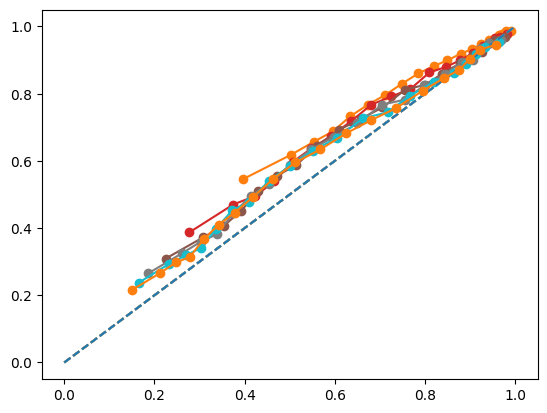

In [7]:
def expected_calibration_error(y, proba, bins = 'fd'):
    bin_count, bin_edges = np.histogram(proba, bins = bins)
    n_bins = len(bin_count)
    bin_edges[0] -= 1e-8 # because left edge is not included
    bin_id = np.digitize(proba, bin_edges, right = True) - 1
    bin_ysum = np.bincount(bin_id, weights = y, minlength = n_bins)
    bin_probasum = np.bincount(bin_id, weights = proba, minlength = n_bins)
    bin_ymean = np.divide(bin_ysum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
    bin_probamean = np.divide(bin_probasum, bin_count, out = np.zeros(n_bins), where = bin_count > 0)
    ece = np.abs((bin_probamean - bin_ymean) * bin_count).sum() / len(proba)
    return ece

bi = 20

for n in [10, 20, 30, 40, 50, 60]:
    name = 'model_'+str(n)+'.pkd'
    with open(name, "rb") as f:
        model = dill.load(f)
    y=y_options[n]

    y_pred = model.predict(X)
    acc = metrics.accuracy_score(y, y_pred)
    prece = metrics.precision_score(y, y_pred)
    rec = metrics.recall_score(y, y_pred)

    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y, probs)
    AUC = round(metrics.auc(recalls, precisions), 4)
    
    prob_true, prob_pred = calibration_curve(y, probs, n_bins=bi,strategy = 'quantile', normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
    plt.plot(prob_pred, prob_true, marker = 'o')
    print(expected_calibration_error(y, probs, bins = bi))


0.03849015615952586
0.07843707625022793
0.09164360839755367
0.07486935115705037
0.06714462628231849
0.06604472760761133


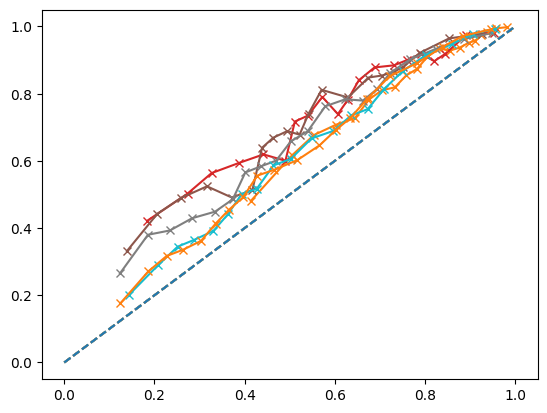

In [8]:
for n in [10, 20, 30, 40, 50, 60]:
    name = 'rf_model_'+str(n)+'.pkd'
    with open(name, "rb") as f:
        model = dill.load(f)
    y=y_options[n]

    y_pred = model.predict(X)
    acc = metrics.accuracy_score(y, y_pred)
    prece = metrics.precision_score(y, y_pred)
    rec = metrics.recall_score(y, y_pred)

    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y, probs)
    AUC = round(metrics.auc(recalls, precisions), 4)
    
    prob_true, prob_pred = calibration_curve(y, probs, n_bins=bi,strategy = 'quantile', normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
    plt.plot(prob_pred, prob_true, marker = 'x')
    print(expected_calibration_error(y, probs, bins = bi))